## Research Topic / Trading Idea

### Do large divergences between Dow Jones and Nasdaq indicate trading opportunities ?

+ **Divergences on what? Prices or returns? Daily returns or cumulative returns?**
+ **Is it easy to get historical index prices?**
+ **How do we define "large" divergences? Sigma? Sigma of what?**
+ **What are trading opportunities?**

In [1]:
from gmbp_quant.common.utils.notebook_utils import set_width_global, disable_auto_scroll
set_width_global()
disable_auto_scroll()
import seaborn as sns
sns.set()
import plotly.express as px

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import gmbp_quant.common.utils.datetime_utils as dtu
from gmbp_quant.dpl.tiingo.tiingo_eod_api import request_historical_daily_prices
from importlib import reload
import gmbp_quant.research.signal_mining.event_analysis
reload(gmbp_quant.research.signal_mining.event_analysis)
from gmbp_quant.research.signal_mining.event_analysis import summarize_event_details

from gmbp_quant.common.logger import LOG
logger = LOG.get_logger(__name__)

ModuleNotFoundError: No module named 'gmbp_quant'

In [2]:
pip install gmbp_quant

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement gmbp_quant (from versions: none)
ERROR: No matching distribution found for gmbp_quant


## Load 10 years' daily EOD prices for Index ETFs and calculate daily returns

#### Historical Index prices are not easy to find, partially because the Index symbols are not consistent among data sources. Thus Index ETFs in this research report.

In [2]:
def load_historical_prices(symbol, start_dateid, end_dateid):
    prices = request_historical_daily_prices(symbol=symbol, start_dateid=start_dateid, end_dateid=end_dateid)
    prices.sort_values('date', ascending=True, inplace=True)
    prices.set_index('date', inplace=True)
    prices['Return'] = prices['adjClose'].pct_change()
    return prices
#

In [3]:
start_dateid, end_dateid = 20080101, 20210312
spy = load_historical_prices(symbol='SPY', start_dateid=start_dateid, end_dateid=end_dateid)
dia = load_historical_prices(symbol='DIA', start_dateid=start_dateid, end_dateid=end_dateid)
qqq = load_historical_prices(symbol='QQQ', start_dateid=start_dateid, end_dateid=end_dateid)

### Put together daily returns and cummulative returns

In [4]:
returns = pd.concat([dia[['Return']], spy[['Return']], qqq[['Return']]], axis=1, sort=False)
returns.columns = ['Return.DIA','Return.SPY','Return.QQQ']
for col in ['DIA','SPY','QQQ']:
    returns[f'CumReturn.{col}'] = returns[f'Return.{col}'].add(1, fill_value=0)
    returns[f'CumMV.{col}'] = returns[f'CumReturn.{col}'].cumprod()
    returns[f'CumReturn.{col}'] = returns[f'CumMV.{col}']-1
#
returns.head()

,Return.DIA,Return.SPY,Return.QQQ,CumReturn.DIA,CumMV.DIA,CumReturn.SPY,CumMV.SPY,CumReturn.QQQ,CumMV.QQQ
date,,,,,,,,,
2008-01-02 00:00:00+00:00,NaN,NaN,NaN,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2008-01-03 00:00:00+00:00,0.000842,-0.000483,0.003370,0.000842,1.000842,-0.000483,0.999517,0.003370,1.003370
2008-01-04 00:00:00+00:00,-0.019657,-0.024506,-0.043856,-0.018832,0.981168,-0.024978,0.975022,-0.040634,0.959366
2008-01-07 00:00:00+00:00,-0.000858,-0.000849,-0.004752,-0.019674,0.980326,-0.025806,0.974194,-0.045193,0.954807
2008-01-08 00:00:00+00:00,-0.017258,-0.016148,-0.025950,-0.036592,0.963408,-0.041537,0.958463,-0.069970,0.930030


In [22]:
fig = px.line(returns.reset_index(), x="date", y=['CumReturn.DIA','CumReturn.SPY','CumReturn.QQQ'],
              hover_data={"date": "|%B %d, %Y"},
              title=f'Cummulative Returns')
# fig.update_xaxes(
#     dtick="M1",
#     tickformat="%b\n%Y")
fig.show()

### Data Quality Check

**Usually this takes lots of time**

## Define "Event" and "Observation" in quantitative way

+ **Event: $abs(normalized(Return_{DIA}-Return_{QQQ}))>T(T=2,3)$, where $\mu_{past}$ and $\sigma_{past}$ are statistics of $Return_{DIA}-Return_{QQQ}$ from the past 2 years before current quarter.**
+ **Observation: $Return_{QQQ}^{01D}$, $Return_{QQQ}^{03D}$, $Return_{QQQ}^{05D}$, $Return_{QQQ}^{10D}$, $Return_{QQQ}^{21D}$** ???

In [5]:
def is_event(miu, sigma, threshold, delta=None, dia_return=None, qqq_return=None):
    if delta is None:
        if dia_return is None or qqq_return is None:
            raise Exception(f'Please provide either "delta" or ("dia_return", "qqq_return") !')
        #
        delta = dia_return - qqq_return
    #
    norm_delta = (delta - miu) / sigma
    return abs(norm_delta)>threshold
#


def infer_quarter_start_end(dateid):
    year = int(dateid/10000)
    month = int(str(dateid)[4:6])
    quarter_month = int((month-1)/3) * 3 + 1

    quarter_start_date = datetime(year=year, month=quarter_month, day=1)
    if quarter_month!=10:
        quarter_end_date = datetime(year=year, month=quarter_month+3, day=1) - timedelta(days=1)        
    else:
        quarter_end_date = datetime(year=year, month=12, day=31)
    #
    
    #logger.info(f"quarter_start_date={quarter_start_date.strftime('%Y-%m-%d')}, quarter_end_date={quarter_end_date.strftime('%Y-%m-%d')} inferred from dateid={dateid}")
    return quarter_start_date, quarter_end_date
#


def get_past_stats(returns, dateid, mode='QUARTER_START', hist_years=2):
    if mode=='QUARTER_START':
        quarter_start_date, quarter_end_date = infer_quarter_start_end(dateid=dateid)
                
        past_end_date = quarter_start_date - timedelta(days=1)
        past_start_date = past_end_date - timedelta(days=hist_years*365)
        
        past_returns = returns.loc[past_start_date.strftime('%Y-%m-%d'):past_end_date.strftime('%Y-%m-%d')]
        delta = past_returns['Return.DIA'] - past_returns['Return.QQQ']
        return delta.mean(), delta.std()
        
    else:
        raise Exception(f'"mode"={mode} is not supported in [QUARTER_START] !')
    #
#

def prepare_quarterly_stats(returns):
#     today = dtu.today()    
    quarterly_stats = dict()
    for year in range(2010, 2022):
        for month_date in ['0201', '0501', '0801', '1101']:            
            dateid = int(f'{year}{month_date}')
            if dateid>20210331:
                break
            #
            quarter_start_date, quarter_end_date = infer_quarter_start_end(dateid=dateid)
            miu, sigma = get_past_stats(returns, dateid, mode='QUARTER_START', hist_years=2)
            logger.info(f"Quarter [{quarter_start_date}, {quarter_end_date}] => miu={miu}, sigma={sigma}")
            
            quarterly_stats[(quarter_start_date, quarter_end_date)] = (miu, sigma)
        #
    #
    return quarterly_stats
#   

def sift_events(returns, start_dateid, end_dateid, quarterly_stats):
    returns = returns.copy()    
    returns['ReturnDiff.DIA-QQQ'] = returns['Return.DIA'] - returns['Return.QQQ']    
    returns = returns.loc[dtu.dateid_to_datestr(dateid=start_dateid, sep='-'):dtu.dateid_to_datestr(dateid=end_dateid, sep='-')]
    returns['DateCnt'] = range(len(returns))
    
    events = list()
    for date,row in returns.iterrows():
        dateid = dtu.datetime_to_dateid(date=date)
        quarter_start_date, quarter_end_date = infer_quarter_start_end(dateid=dateid)
        miu, sigma = quarterly_stats[(quarter_start_date, quarter_end_date)]
        threshold = 3
        if is_event(miu=miu, sigma=sigma, threshold=threshold, delta=row['ReturnDiff.DIA-QQQ']):            
            date_index = row['DateCnt']            
            qqq_01d = returns[returns['DateCnt']==date_index+1]
            qqq_01d = qqq_01d['Return.QQQ'].values[0] if len(qqq_01d)>0 else None 
            qqq_03d = returns[returns['DateCnt']==date_index+3]
            qqq_03d = (qqq_03d['CumReturn.QQQ'].values[0]+1)/(row['CumReturn.QQQ']+1)-1 if len(qqq_03d)>0 else None
            qqq_05d = returns[returns['DateCnt']==date_index+5]
            qqq_05d = (qqq_05d['CumReturn.QQQ'].values[0]+1)/(row['CumReturn.QQQ']+1)-1 if len(qqq_05d)>0 else None
            qqq_10d = returns[returns['DateCnt']==date_index+10]
            qqq_10d = (qqq_10d['CumReturn.QQQ'].values[0]+1)/(row['CumReturn.QQQ']+1)-1 if len(qqq_10d)>0 else None
            qqq_21d = returns[returns['DateCnt']==date_index+21]
            qqq_21d = (qqq_21d['CumReturn.QQQ'].values[0]+1)/(row['CumReturn.QQQ']+1)-1 if len(qqq_21d)>0 else None
            
            event_row = {'date':date, 'Return.DIA':row['Return.DIA'], 'Return.QQQ':row['Return.QQQ'], 'ReturnDiff.DIA-QQQ':row['ReturnDiff.DIA-QQQ'],
                         'miu':miu, 'sigma':sigma, 'divergence': (row['ReturnDiff.DIA-QQQ']-miu)/sigma,
                         'CumReturn.QQQ.01D':qqq_01d, 'CumReturn.QQQ.03D':qqq_03d, 'CumReturn.QQQ.05D':qqq_05d, 'CumReturn.QQQ.10D':qqq_10d, 'CumReturn.QQQ.21D':qqq_21d}
            events.append(event_row)
        #
    #
    return pd.DataFrame(events), returns
#        
    

In [6]:
quarterly_stats = prepare_quarterly_stats(returns=returns)

[I 2021-03-22 13:34:11,922 <ipython-input-5-1935a721ff03>:prepare_quarterly_stats] - Quarter [2010-01-01 00:00:00, 2010-03-31 00:00:00] => miu=-0.00017842203284434448, sigma=0.009221881088915666
[I 2021-03-22 13:34:11,934 <ipython-input-5-1935a721ff03>:prepare_quarterly_stats] - Quarter [2010-04-01 00:00:00, 2010-06-30 00:00:00] => miu=-0.0003537798506785597, sigma=0.008707491693216579
[I 2021-03-22 13:34:11,943 <ipython-input-5-1935a721ff03>:prepare_quarterly_stats] - Quarter [2010-07-01 00:00:00, 2010-09-30 00:00:00] => miu=-8.199984857284239e-05, sigma=0.008415101821272612
[I 2021-03-22 13:34:11,949 <ipython-input-5-1935a721ff03>:prepare_quarterly_stats] - Quarter [2010-10-01 00:00:00, 2010-12-31 00:00:00] => miu=-0.00038320550683989505, sigma=0.007660694916928965
[I 2021-03-22 13:34:11,958 <ipython-input-5-1935a721ff03>:prepare_quarterly_stats] - Quarter [2011-01-01 00:00:00, 2011-03-31 00:00:00] => miu=-0.0005765567849576527, sigma=0.0058968489349783375
[I 2021-03-22 13:34:11,963 

[I 2021-03-22 13:34:12,328 <ipython-input-5-1935a721ff03>:prepare_quarterly_stats] - Quarter [2020-10-01 00:00:00, 2020-12-31 00:00:00] => miu=-0.0006631121549361352, sigma=0.008384611178066093
[I 2021-03-22 13:34:12,340 <ipython-input-5-1935a721ff03>:prepare_quarterly_stats] - Quarter [2021-01-01 00:00:00, 2021-03-31 00:00:00] => miu=-0.000822384256056786, sigma=0.008879609782840813


In [7]:
events, returns_in_date_range = sift_events(returns=returns, start_dateid=20100101, end_dateid=20210312, quarterly_stats=quarterly_stats)
events_pos = events[events['divergence']>0]
events_neg = events[events['divergence']<0]

In [8]:
events_pos

,date,Return.DIA,Return.QQQ,ReturnDiff.DIA-QQQ,miu,sigma,divergence,CumReturn.QQQ.01D,CumReturn.QQQ.03D,CumReturn.QQQ.05D,CumReturn.QQQ.10D,CumReturn.QQQ.21D
1,2011-09-29 00:00:00+00:00,0.014113,-0.011920,0.026033,-0.000091,0.004969,5.257547,-0.025798,-0.031366,0.010208,0.060134,0.093912
2,2012-04-16 00:00:00+00:00,0.005218,-0.011180,0.016398,-0.000238,0.005469,3.041934,0.020321,0.006264,-0.005653,0.020015,-0.031780
4,2012-12-05 00:00:00+00:00,0.006569,-0.011074,0.017643,-0.000186,0.005688,3.134741,0.006422,0.003340,0.014280,0.020913,0.032695
5,2013-01-24 00:00:00+00:00,0.004074,-0.013759,0.017833,-0.000077,0.005718,3.132316,0.005101,0.007501,0.003150,0.009601,-0.005251
6,2014-04-04 00:00:00+00:00,-0.008830,-0.026598,0.017767,-0.000058,0.004995,3.568659,-0.009494,0.016788,-0.026166,0.005442,0.005094
7,2014-04-10 00:00:00+00:00,-0.016027,-0.030972,0.014946,-0.000058,0.004995,3.003769,-0.011633,-0.000586,0.012926,0.012808,0.036780
8,2014-10-10 00:00:00+00:00,-0.006793,-0.024985,0.018191,-0.000232,0.004745,3.882933,-0.015671,-0.021919,-0.015248,0.044261,0.079627
10,2015-09-25 00:00:00+00:00,0.006240,-0.008478,0.014717,-0.000450,0.004594,3.301141,-0.028566,-0.011465,0.010591,0.035076,0.096483
13,2016-02-03 00:00:00+00:00,0.011090,-0.004797,0.015887,-0.000357,0.004678,3.472476,-0.000098,-0.049577,-0.048888,-0.003246,0.039445
14,2016-02-05 00:00:00+00:00,-0.013403,-0.034727,0.021324,-0.000357,0.004678,4.634822,-0.015287,-0.014574,-0.001019,0.052589,0.061455


In [9]:
events_neg

,date,Return.DIA,Return.QQQ,ReturnDiff.DIA-QQQ,miu,sigma,divergence,CumReturn.QQQ.01D,CumReturn.QQQ.03D,CumReturn.QQQ.05D,CumReturn.QQQ.10D,CumReturn.QQQ.21D
0,2010-10-15 00:00:00+00:00,-0.002674,0.021222,-0.023896,-0.000383,0.007661,-3.069288,-0.003690,-0.005826,0.002913,0.013401,0.016023
3,2012-04-25 00:00:00+00:00,0.007092,0.026572,-0.019480,-0.000238,0.005469,-3.518309,0.005869,0.004665,0.009180,-0.032039,-0.064710
9,2015-07-17 00:00:00+00:00,-0.001977,0.014740,-0.016717,-0.000450,0.004594,-3.540684,0.003433,-0.008539,-0.021921,-0.014438,-0.019016
11,2015-10-23 00:00:00+00:00,0.009386,0.027983,-0.018597,-0.000348,0.004738,-3.851965,0.000621,0.010995,0.004877,0.017822,0.012148
12,2016-01-22 00:00:00+00:00,0.013808,0.028954,-0.015146,-0.000357,0.004678,-3.161513,-0.014841,-0.030741,0.003469,-0.054447,-0.021104
15,2016-02-11 00:00:00+00:00,-0.016249,-0.001448,-0.014802,-0.000357,0.004678,-3.087964,0.015225,0.061626,0.052615,0.071258,0.104816
21,2017-10-27 00:00:00+00:00,0.001368,0.029124,-0.027755,-0.000039,0.005189,-5.341450,0.002248,0.005686,0.013422,0.016133,0.035374
26,2018-10-25 00:00:00+00:00,0.016813,0.034595,-0.017782,-0.000118,0.005830,-3.029844,-0.025722,-0.030048,0.005846,0.019876,-0.047761
28,2020-03-17 00:00:00+00:00,0.054225,0.075842,-0.021617,-0.000320,0.006070,-3.508634,-0.030416,-0.062809,0.010491,0.047574,0.173294
29,2020-03-18 00:00:00+00:00,-0.065958,-0.030416,-0.035542,-0.000320,0.006070,-5.802686,0.006002,-0.032714,0.034473,0.034529,0.221677


In [28]:
# (1+0.0281566)*(1+0.007432394)*(1+0.007945)*(1+0.01931198)*(1+0.01165488)-1

In [29]:
fig = px.line(returns.reset_index(), x="date", y=['Return.DIA','Return.QQQ'],
              hover_data={"date": "|%B %d, %Y"},
              title=f'Returns')
fig.show()

## Summary on Events

### Capacity

In [30]:
print(f"There are in total {len(events)} dates on which events are observed out of {len(returns_in_date_range)} dates ({round(len(events)/len(returns_in_date_range)*100, 2)}%)")
print(f"DIA-QQQ>3sigma: {len(events_pos)}; DIA-QQQ<3sigma: {len(events_neg)}")

There are in total 47 dates on which events are observed out of 2817 dates (1.67%)
DIA-QQQ>3sigma: 31; DIA-QQQ<3sigma: 16


### Alpha Curve

<AxesSubplot:>

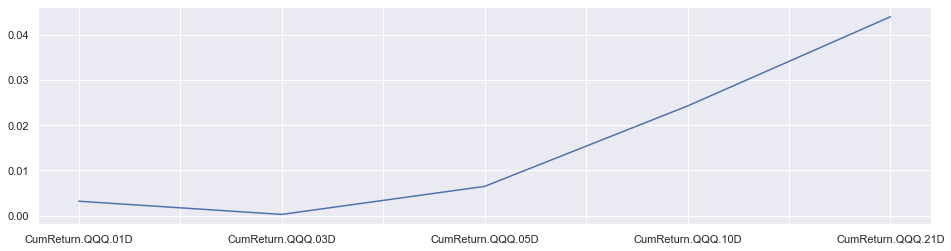

In [31]:
events_pos[['CumReturn.QQQ.01D','CumReturn.QQQ.03D','CumReturn.QQQ.05D','CumReturn.QQQ.10D','CumReturn.QQQ.21D']].mean().plot(figsize=(16,4))

<AxesSubplot:>

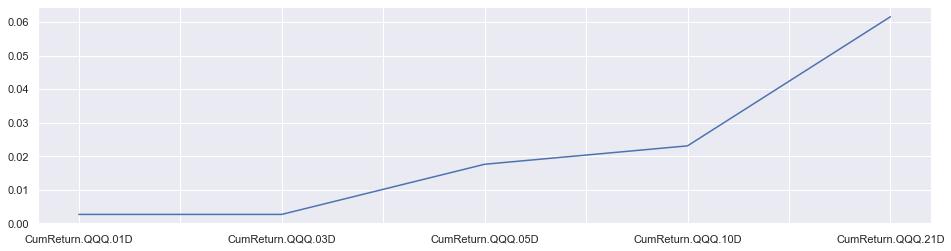

In [32]:
events_neg[['CumReturn.QQQ.01D','CumReturn.QQQ.03D','CumReturn.QQQ.05D','CumReturn.QQQ.10D','CumReturn.QQQ.21D']].mean().plot(figsize=(16,4))

### Win Rates

In [33]:
events_pos[['CumReturn.QQQ.01D','CumReturn.QQQ.03D','CumReturn.QQQ.05D','CumReturn.QQQ.10D','CumReturn.QQQ.21D']].apply(lambda x : len(x[x>0])/len(x))

CumReturn.QQQ.01D    0.483871
CumReturn.QQQ.03D    0.483871
CumReturn.QQQ.05D    0.612903
CumReturn.QQQ.10D    0.806452
CumReturn.QQQ.21D    0.741935
dtype: float64

In [34]:
events_neg[['CumReturn.QQQ.01D','CumReturn.QQQ.03D','CumReturn.QQQ.05D','CumReturn.QQQ.10D','CumReturn.QQQ.21D']].apply(lambda x : len(x[x>0])/len(x))

CumReturn.QQQ.01D    0.5625
CumReturn.QQQ.03D    0.5000
CumReturn.QQQ.05D    0.7500
CumReturn.QQQ.10D    0.6875
CumReturn.QQQ.21D    0.6875
dtype: float64

## Compile Event Summary by a shared function

In [24]:
return_cols = [f'CumReturn.QQQ.{num_days}D' for num_days in ['01','03','05','10','21']]
summary_events_pos = summarize_event_details(event_details=events_pos, return_cols=return_cols)
summary_events_pos

,CumReturn.QQQ.01D,CumReturn.QQQ.03D,CumReturn.QQQ.05D,CumReturn.QQQ.10D,CumReturn.QQQ.21D
Avg,0.003173,0.000247,0.006455,0.024265,0.044030
WinRate,0.483871,0.483871,0.612903,0.806452,0.741935
t-stats,0.888243,0.055175,1.325471,3.406448,4.647590
p-value,0.381477,0.956365,0.195363,0.001947,0.000073


In [26]:
summary_events_neg = summarize_event_details(event_details=events_neg, return_cols=return_cols)
summary_events_neg

,CumReturn.QQQ.01D,CumReturn.QQQ.03D,CumReturn.QQQ.05D,CumReturn.QQQ.10D,CumReturn.QQQ.21D
Avg,0.002682,0.002681,0.017613,0.023096,0.061544
WinRate,0.562500,0.500000,0.750000,0.687500,0.687500
t-stats,0.362068,0.234508,1.833238,1.834504,2.585079
p-value,0.722351,0.817762,0.088114,0.087916,0.021595
